# Autoencoder

## Motivation
We train an autoencoder using all of the EEG signals, use the trained autoencoder to augment the signals, and validate on the downstream task of seizure detection.

**Note: To run this notebook, it is highly recommended to use GPU.**

## I. Train an autoencoder
- Processing: Min-max scaling
- Encoder: Inception Nucleus: https://ieeexplore.ieee.org/document/9054725
- Decoder: Reverse process of the encoder
- Hyperparameters:
    - loss function: mse
    - optimizer: Adam
    - learning rate: 0.0001
    - epochs: 10
    - batch_size: 32
    - early stopping: 5 patience epochs after validation loss stops deacreasing.

### Model

In [1]:
# Import necessary
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, Conv1DTranspose, Dropout, Dense, Flatten

gpus = tf.config.list_physical_devices('GPU')
device = '/device:GPU:0' if gpus else '/device:CPU:0'
print(f"Using device: {device}")

2024-11-28 22:38:45.988128: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 22:38:46.033742: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 22:38:46.033764: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 22:38:46.033771: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 22:38:46.040352: I tensorflow/core/platform/cpu_feature_g

Using device: /device:GPU:0


2024-11-28 22:38:47.704162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-28 22:38:47.740006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-28 22:38:47.743293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
# Model architecture

def InceptionNucleusEncoder(input_layer, filters, one_d_dropout_rate=0):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(one_d_dropout_rate)(x)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def InceptionNucleusTranspose(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1DTranspose(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_autoencoder(one_d_dropout_rate=0, two_d_dropout_rate=0):
    ## input size: (batch_size, 178, 1) or (178, 1)
    ## Output size: (batch_size, 178, 1) or (1, 178, 1)

    # Encoder
    inputs = Input(shape=(178,))  # Change input shape to (178,) to match your data
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)  # Add channel dimension for processing

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleusEncoder(x, filters=[4, 8, 12], one_d_dropout_rate=one_d_dropout_rate)

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x)

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(two_d_dropout_rate)(x)
    encoded = MaxPooling2D((2, 2))(x)  # Compressed representation (encoder output)

    # Decoder: reverse the encoder
    x = UpSampling2D((2, 2))(encoded)  # Reverse the max-pooling
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Reshape back to 1D format for InceptionNucleusTranspose
    x = Reshape((178, 96 * 64))(x)  # Flatten the feature maps
    x = Conv1D(96, kernel_size=1, activation='relu')(x)  # Reduce feature maps from 96 * 64 to 96

    # InceptionNucleusTranspose: reverse the multi-scale convolutions
    x = InceptionNucleusTranspose(x, filters=[4, 8, 12])

    # Final reconstruction layer to original input dimensions
    outputs = Conv1D(1, kernel_size=1, padding='same', activation='sigmoid')(x)

    # Autoencoder Model
    autoencoder = Model(inputs=inputs, outputs=outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

autoencoder = create_eeg_autoencoder()
print ("Autoencoder:")
autoencoder.summary()

2024-11-28 22:38:51.050862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-28 22:38:51.055509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-28 22:38:51.058540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Autoencoder:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 178)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 178, 1)               0         ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 178, 32)              160       ['lambda[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)           (None, 178, 32)              288       ['lambda[0][0]']              
                                                                                 

In [3]:
# Load data
def load_train_hard_test_split():
    train_data = pd.read_csv('../data/hard_test_cases/train.csv', index_col=0)
    test_data = pd.read_csv('../data/hard_test_cases/test.csv', index_col=0)

    X_train = train_data.iloc[:, :-1].values  # X1-X178
    X_test = test_data.iloc[:, :-1].values    # X1-X178

    # Normalize the data using min-max scaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data for the model
    X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
    X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

    # y data
    y_train = train_data['y']
    y_test = test_data['y']
    y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
    
    return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler

In [4]:
# Define the main function to train the autoencoder
def train(device, X_train, X_test, epochs=3, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0):
    
    with tf.device(device): 
        # Define and compile the autoencoder
        autoencoder = create_eeg_autoencoder(one_d_dropout_rate=one_d_dropout_rate, two_d_dropout_rate=two_d_dropout_rate)
        autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the autoencoder
        history = autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
    
    with tf.device(device): 
        # Evaluate on test data
        test_loss = autoencoder.evaluate(X_test, X_test)
        print("Test loss (reconstruction error):", test_loss)

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return autoencoder


# Visualization signal
def visualize(original_signal, augmented_signal, title="Augmented Signal"):
    """
    Visualize the original and augmented signals on the same plot.

    Parameters:
    - original_signal: numpy array, the original time-series signal.
    - augmented_signal: numpy array, the augmented time-series signal.
    - title: str, title for the plot.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(original_signal, label="Original Signal", color="blue", alpha=0.7)
    plt.plot(augmented_signal, label="Augmented Signal", color="red", alpha=0.7)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


## Experimenting with Dropout

To make the autoencoder more robust, we incorporate dropout into the model.

### Key Considerations:
Dropout is applied only in the encoder. This helps the model generalize better by regularizing the feature extraction process. Avoiding dropout in the decoder ensures the decoder focuses on accurately reconstructing the input, which is critical for tasks like autoencoding. This approach is a common practice in autoencoders and other neural networks as it strikes a balance between regularization and accurate output generation.

---

### Experiments:

**Three variations of dropout placement were tested:**
1. **Experiment 1**: No dropout.
2. **Experiment 2**: Dropout after 1D convolutional layers.
3. **Experiment 3**: Dropout after 2D convolutional layers.

For each variation, two dropout rates were tested: **0.25** and **0.5**.

In [4]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_hard_test_split()

### 1. No dropout

Epoch 1/10
256/256 [==============================] - 24s 79ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 2/10
256/256 [==============================] - 20s 79ms/step - loss: 1.8018e-04 - val_loss: 0.0029
Epoch 3/10
256/256 [==============================] - 20s 79ms/step - loss: 1.0861e-04 - val_loss: 2.4834e-04
Epoch 4/10
256/256 [==============================] - 20s 79ms/step - loss: 8.3457e-05 - val_loss: 6.7847e-05
Epoch 5/10
256/256 [==============================] - 20s 79ms/step - loss: 6.7035e-05 - val_loss: 6.4740e-05
Epoch 6/10
256/256 [==============================] - 20s 79ms/step - loss: 5.6146e-05 - val_loss: 6.2610e-05
Epoch 7/10
256/256 [==============================] - 20s 79ms/step - loss: 4.9452e-05 - val_loss: 3.4531e-05
Epoch 8/10
256/256 [==============================] - 20s 79ms/step - loss: 4.2143e-05 - val_loss: 3.8533e-05
Epoch 9/10
256/256 [==============================] - 20s 79ms/step - loss: 3.9834e-05 - val_loss: 4.0396e-05
Epoch 10/10
40/40 [===

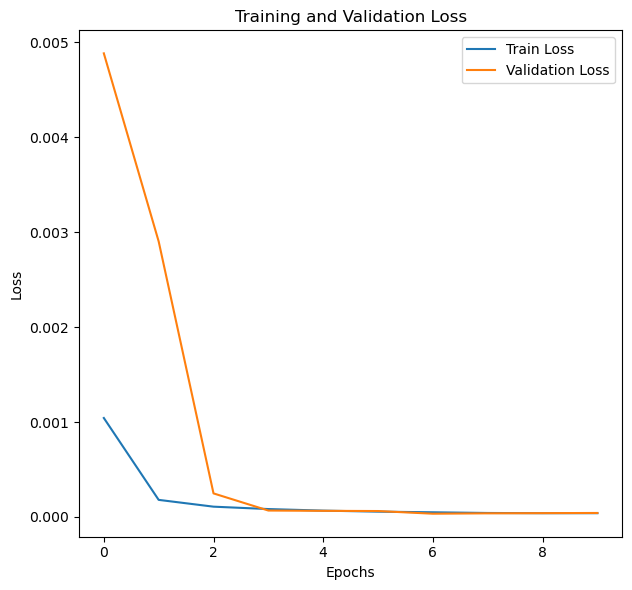

In [85]:
autoencoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0)

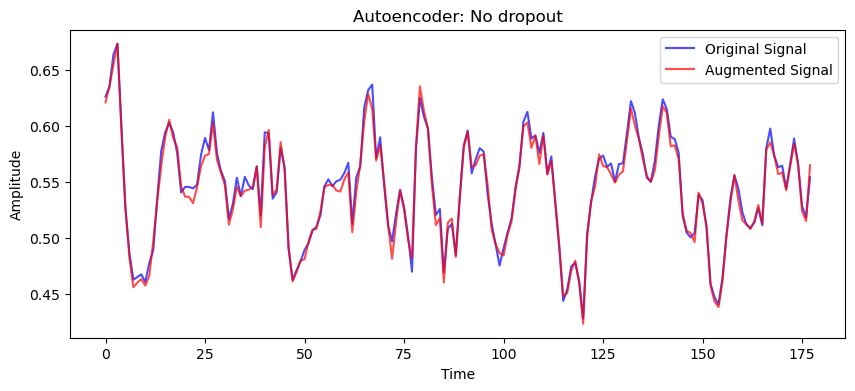

In [86]:
reconstructed_signal = autoencoder.predict(X_test_scaled[0][np.newaxis, :, :],verbose=0)
visualize(X_test_scaled[0].squeeze(), reconstructed_signal.squeeze(), title="Autoencoder: No dropout")

In [87]:
# Save the autoencoder model
model_path = "../models/autoencoder.h5"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
autoencoder.save(model_path)
print("Autoencoder model saved as 'autoencoder.h5'")

Autoencoder model saved as 'autoencoder.h5'


/opt/conda/envs/capstone/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 2. Dropout after 1D conv

#### 2.1 Dropout rate=0.25

Epoch 1/10
256/256 [==============================] - 27s 84ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 2/10
256/256 [==============================] - 20s 79ms/step - loss: 3.6643e-04 - val_loss: 0.0025
Epoch 3/10
256/256 [==============================] - 20s 79ms/step - loss: 2.3742e-04 - val_loss: 5.2598e-04
Epoch 4/10
256/256 [==============================] - 20s 79ms/step - loss: 1.8434e-04 - val_loss: 1.3887e-04
Epoch 5/10
256/256 [==============================] - 20s 79ms/step - loss: 1.5461e-04 - val_loss: 2.1701e-04
Epoch 6/10
256/256 [==============================] - 20s 79ms/step - loss: 1.3423e-04 - val_loss: 2.0788e-04
Epoch 7/10
256/256 [==============================] - 20s 79ms/step - loss: 1.2051e-04 - val_loss: 2.4413e-04
Epoch 8/10
256/256 [==============================] - 20s 79ms/step - loss: 1.0532e-04 - val_loss: 1.6560e-04
Epoch 9/10
40/40 [==============================] - 1s 23ms/step - loss: 1.6317e-04
Test loss (reconstruction error): 0.000163167438

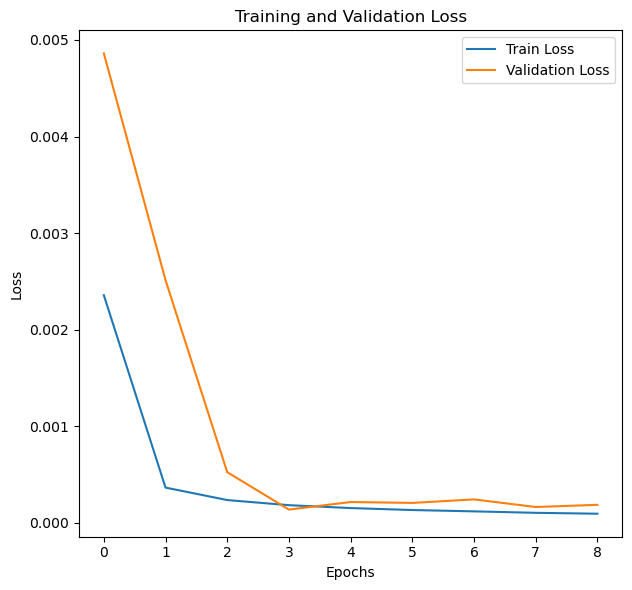

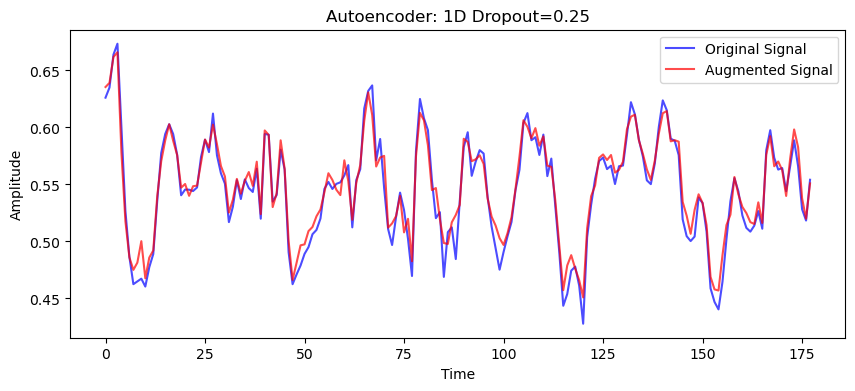

In [70]:
autoencoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0.25, two_d_dropout_rate=0)
reconstructed_signal = autoencoder.predict(X_test_scaled[0][np.newaxis, :, :],verbose=0)
visualize(X_test_scaled[0].squeeze(), reconstructed_signal.squeeze(), title="Autoencoder: 1D Dropout=0.25")

#### 2.2 Dropout rate=0.5

Epoch 1/10
256/256 [==============================] - 25s 80ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 2/10
256/256 [==============================] - 20s 79ms/step - loss: 3.7038e-04 - val_loss: 0.0029
Epoch 3/10
256/256 [==============================] - 20s 79ms/step - loss: 2.6224e-04 - val_loss: 8.4447e-04
Epoch 4/10
256/256 [==============================] - 20s 79ms/step - loss: 2.1488e-04 - val_loss: 5.5490e-04
Epoch 5/10
256/256 [==============================] - 20s 79ms/step - loss: 1.9252e-04 - val_loss: 5.0493e-04
Epoch 6/10
256/256 [==============================] - 20s 79ms/step - loss: 1.6761e-04 - val_loss: 6.4431e-04
Epoch 7/10
256/256 [==============================] - 20s 79ms/step - loss: 1.6317e-04 - val_loss: 5.8210e-04
Epoch 8/10
256/256 [==============================] - 20s 79ms/step - loss: 1.4195e-04 - val_loss: 6.1653e-04
Epoch 9/10
256/256 [==============================] - 20s 79ms/step - loss: 1.3854e-04 - val_loss: 5.9280e-04
Epoch 10/10
40/40 [===

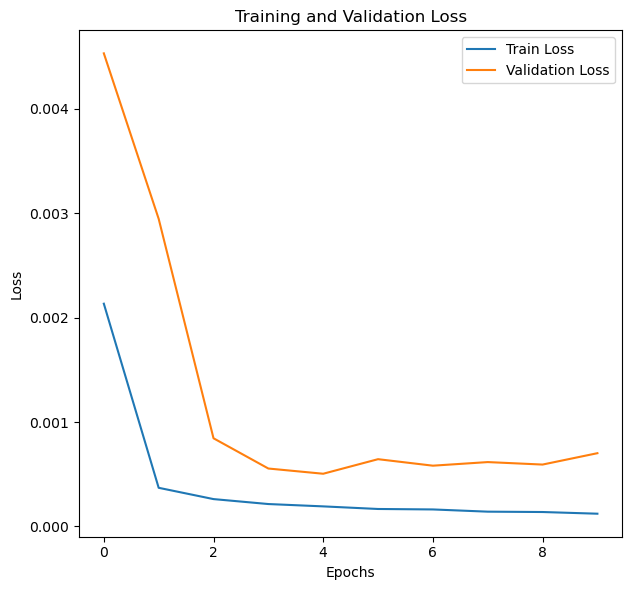

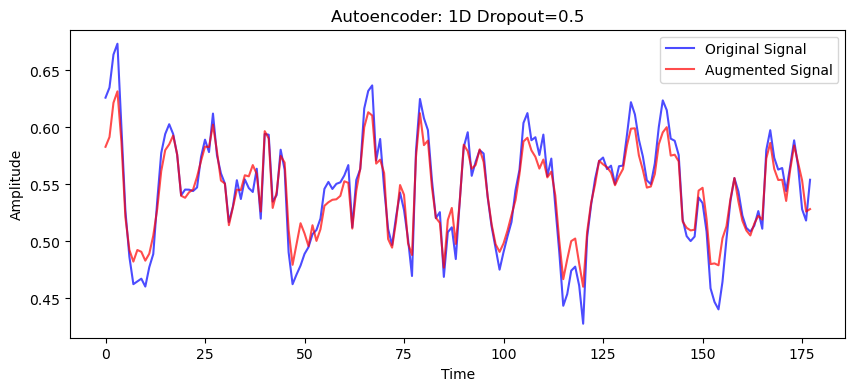

In [71]:
autoencoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0.5, two_d_dropout_rate=0)
reconstructed_signal = autoencoder.predict(X_test_scaled[0][np.newaxis, :, :],verbose=0)
visualize(X_test_scaled[0].squeeze(), reconstructed_signal.squeeze(), title="Autoencoder: 1D Dropout=0.5")

### 3. Dropout after 2D Conv

#### 3.1 Dropout rate=0.25

Epoch 1/10


2024-11-28 05:17:53.950698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-28 05:17:54.729433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-28 05:17:58.915876: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55dbf9b89ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-28 05:17:58.915917: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-28 05:17:58.957295: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 05:17:59.164146: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster usi

256/256 [==============================] - 40s 115ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 2/10
256/256 [==============================] - 27s 105ms/step - loss: 3.1494e-04 - val_loss: 0.0024
Epoch 3/10
256/256 [==============================] - 27s 106ms/step - loss: 2.0545e-04 - val_loss: 3.3604e-04
Epoch 4/10
256/256 [==============================] - 27s 106ms/step - loss: 1.5357e-04 - val_loss: 9.5389e-05
Epoch 5/10
256/256 [==============================] - 27s 106ms/step - loss: 1.2747e-04 - val_loss: 9.0421e-05
Epoch 6/10
256/256 [==============================] - 27s 106ms/step - loss: 1.0476e-04 - val_loss: 7.8595e-05
Epoch 7/10
256/256 [==============================] - 27s 106ms/step - loss: 9.4084e-05 - val_loss: 6.4630e-05
Epoch 8/10
256/256 [==============================] - 27s 106ms/step - loss: 8.0419e-05 - val_loss: 1.1010e-04
Epoch 9/10
256/256 [==============================] - 27s 106ms/step - loss: 7.6037e-05 - val_loss: 9.2550e-05
Epoch 10/10
40/40 [=====

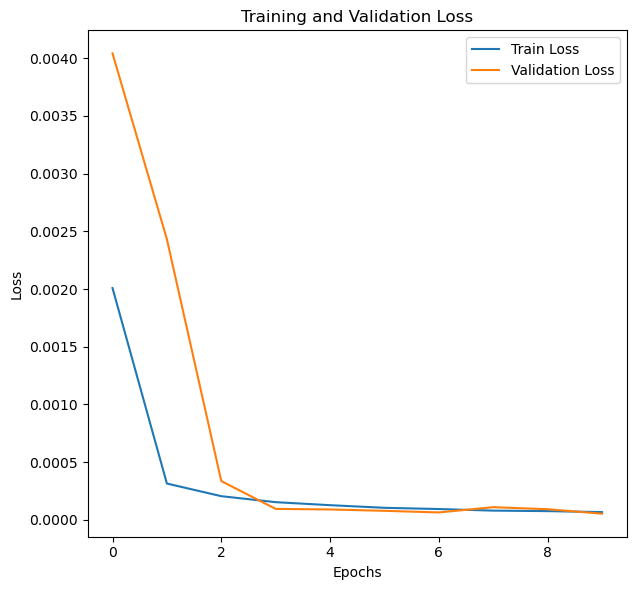

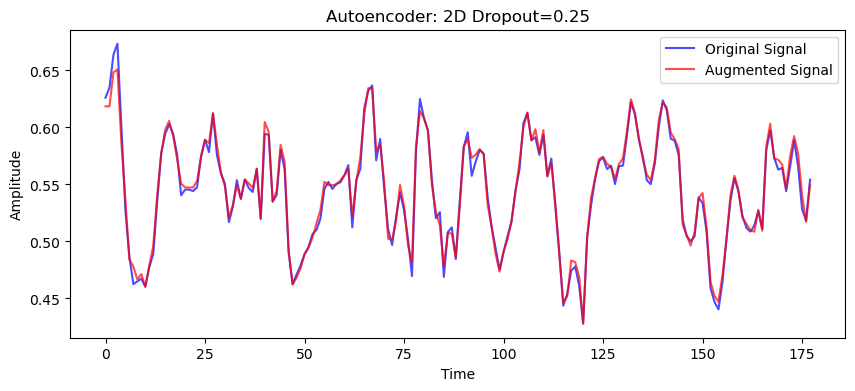

In [6]:
autoencoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.25)
reconstructed_signal = autoencoder.predict(X_test_scaled[0][np.newaxis, :, :],verbose=0)
visualize(X_test_scaled[0].squeeze(), reconstructed_signal.squeeze(), title="Autoencoder: 2D Dropout=0.25")

In [7]:
# Save the autoencoder model
model_path = "../models/autoencoder_2d_dropout.h5"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
autoencoder.save(model_path)

/opt/conda/envs/capstone/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 3.2 Dropout rate=0.5

Epoch 1/10


2024-11-27 20:22:05.709194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/dropout_107/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - 31s 106ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 2/10
256/256 [==============================] - 27s 105ms/step - loss: 3.5076e-04 - val_loss: 0.0024
Epoch 3/10
256/256 [==============================] - 27s 105ms/step - loss: 2.2904e-04 - val_loss: 4.1026e-04
Epoch 4/10
256/256 [==============================] - 27s 105ms/step - loss: 1.7018e-04 - val_loss: 2.7037e-04
Epoch 5/10
256/256 [==============================] - 27s 105ms/step - loss: 1.3878e-04 - val_loss: 2.7443e-04
Epoch 6/10
256/256 [==============================] - 27s 105ms/step - loss: 1.1800e-04 - val_loss: 2.1205e-04
Epoch 7/10
256/256 [==============================] - 27s 105ms/step - loss: 1.0340e-04 - val_loss: 1.9734e-04
Epoch 8/10
256/256 [==============================] - 27s 105ms/step - loss: 1.0253e-04 - val_loss: 1.6030e-04
Epoch 9/10
256/256 [==============================] - 27s 105ms/step - loss: 8.3286e-05 - val_loss: 1.7802e-04
Epoch 10/10
40/40 [=====

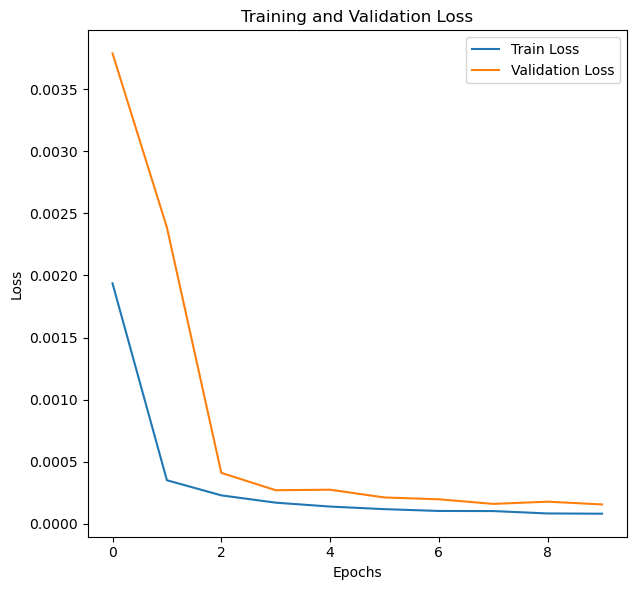

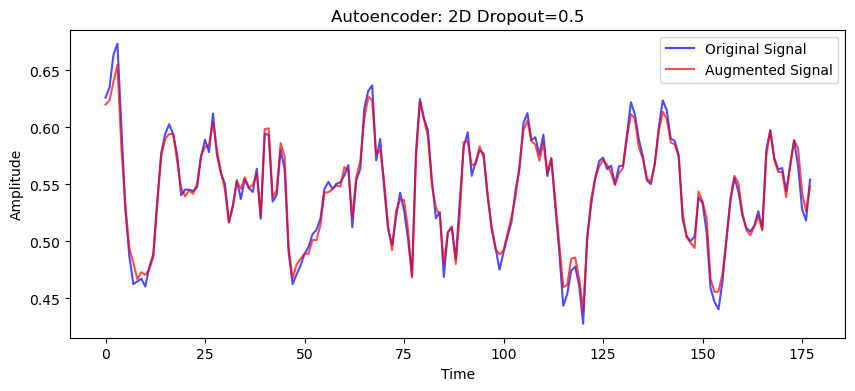

In [74]:
autoencoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.5)
reconstructed_signal = autoencoder.predict(X_test_scaled[0][np.newaxis, :, :],verbose=0)
visualize(X_test_scaled[0].squeeze(), reconstructed_signal.squeeze(), title="Autoencoder: 2D Dropout=0.5")

## II. Evaluation of Augmentation: Seizure Detection

We evaluate the effectiveness of data augmentation on the downstream task of seizure detection.

In [12]:
def evaluate_classification_metrics(y_true, y_pred, y_pred_prob):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision
    precision = precision_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if len(set(y_true)) > 1:
        # Check if ROC-AUC can be calculated (i.e., both classes are present)
        roc_auc = roc_auc_score(y_true, y_pred_prob)
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(y_true, y_pred)
    else:
        roc_auc = None  # Not computable, only one class in y_true
        kappa = None
    
    # Calculate metrics for seizure class (y_label=1)
    precision_seizure = precision_score(y_true, y_pred, pos_label=1)
    recall_seizure = recall_score(y_true, y_pred, pos_label=1)
    f1_seizure = f1_score(y_true, y_pred, pos_label=1)
    
    # Calculate metrics for non-seizure class (y_label=0)
    precision_non_seizure = precision_score(y_true, y_pred, pos_label=0)
    recall_non_seizure = recall_score(y_true, y_pred, pos_label=0)
    f1_non_seizure = f1_score(y_true, y_pred, pos_label=0)
    
    print(f'\nSeizure (y=1):')
    print(f'  Precision: {precision_seizure * 100:.2f} %')
    print(f'  Recall: {recall_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_seizure * 100:.2f} %')
    
    print(f'\nNon-Seizure (y=0):')
    print(f'  Precision: {precision_non_seizure * 100:.2f} %')
    print(f'  Recall: {recall_non_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_non_seizure * 100:.2f} %')
    
    # Print metrics
    print(f'\nOverall:')
    print(f'  Accuracy: {accuracy * 100:.2f} %')
    print(f'  Precision: {precision * 100:.2f} %')
    print(f'  Recall: {recall * 100:.2f} %')
    print(f'  F1 Score: {f1 * 100:.2f} %')
    if roc_auc is not None:
        print(f'  ROC-AUC: {roc_auc * 100:.2f} %')
    if kappa is not None:
        print(f'  Cohen\'s Kappa: {kappa * 100:.2f} %')

### 1. Detection Model

- **Preprocessing**: No normalization. Since we are using challenging test cases, the scaler trained on the training dataset is completely different from the test set. Using the scaler to scale the test data would skew the results.
- **Feature**: Inception Nucleus.
- **Output Dimension**: 1 (Sigmoid activation).
- **Optimizer**: Adam.
- **Loss Function**: Cross-Entropy.
- **Early Stopping**: 5 epochs of patience.
- **Learning Rate**: 0.0001.

In [9]:
def InceptionNucleus(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_cnn(input_shape=(178, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12])

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x) # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten after 2D Convolutions
    x = Flatten()(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_eeg_cnn()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 178, 1)]             0         []                            
                                                                                                  
 conv1d_5 (Conv1D)           (None, 178, 32)              160       ['input_2[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 178, 32)              288       ['input_2[0][0]']             
                                                                                                  
 conv1d_7 (Conv1D)           (None, 178, 32)              416       ['input_2[0][0]']             
                                                                                            

In [8]:
def train_and_test_classification(X_train, y_train, X_test, y_test, lr_rate=0.0001, num_epochs=30):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create the model
    model = create_eeg_cnn(input_shape=(178, 1), num_classes=2)
    
    # Define the optimizer with a specific learning rate
    optimizer = Adam(learning_rate=lr_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model and store the training history
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  
        epochs=num_epochs, 
        batch_size=32,
        shuffle=True,
        callbacks=[early_stopping], 
        verbose=1 
    )
    
    # After training, evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    # Predict class probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities to binary class labels (assuming threshold 0.5)
    y_pred = (y_pred_prob[:, 1] > 0.5).astype(int)
    
    # Evaluate classification metrics using the provided function
    evaluate_classification_metrics(y_test, y_pred, y_pred_prob[:, 1])
    
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    
    # Plot training & validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### 2. Before augmentation

Epoch 1/30
256/256 [==============================] - 7s 21ms/step - loss: 0.4270 - accuracy: 0.9678 - val_loss: 0.1411 - val_accuracy: 0.9873
Epoch 2/30
256/256 [==============================] - 5s 20ms/step - loss: 0.4229 - accuracy: 0.9764 - val_loss: 0.0453 - val_accuracy: 0.9941
Epoch 3/30
256/256 [==============================] - 5s 20ms/step - loss: 0.4887 - accuracy: 0.9799 - val_loss: 0.1594 - val_accuracy: 0.9912
Epoch 4/30
256/256 [==============================] - 5s 20ms/step - loss: 0.3876 - accuracy: 0.9839 - val_loss: 0.2561 - val_accuracy: 0.9868
Epoch 5/30
256/256 [==============================] - 5s 20ms/step - loss: 0.2682 - accuracy: 0.9877 - val_loss: 0.0834 - val_accuracy: 0.9932
Epoch 6/30
256/256 [==============================] - 5s 20ms/step - loss: 0.2685 - accuracy: 0.9867 - val_loss: 0.3560 - val_accuracy: 0.9868
Epoch 7/30
40/40 [==============================] - 0s 4ms/step

Seizure (y=1):
  Precision: 40.00 %
  Recall: 45.24 %
  F1 Score: 42.46 %

No

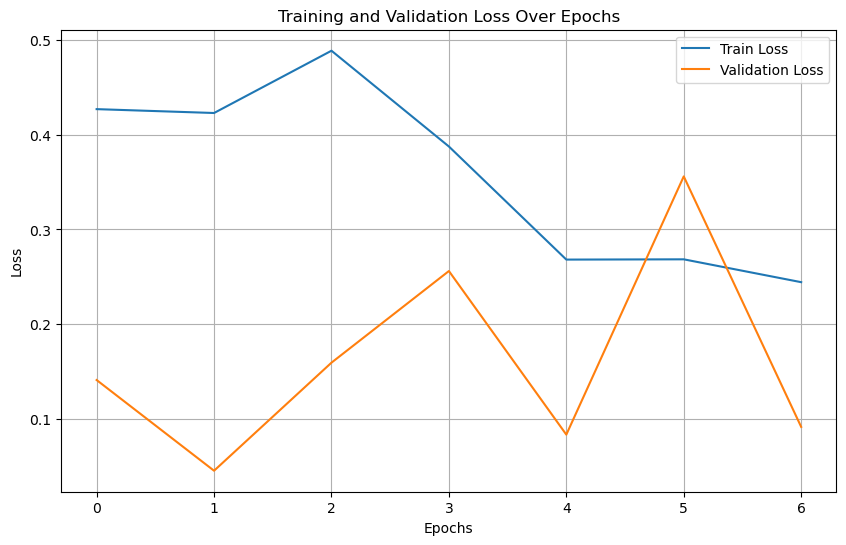

In [20]:
train_and_test_classification(X_train, y_train, X_test, y_test)

### 3. After Augmentation
Feed reconstructed signal back to Autoencoder n times, to create n different augmented version.

In [7]:
# Function to plot original vs augmented signals
def plot_original_vs_augmented(X_original, X_augmented, n_augmentations):
    plt.figure(figsize=(12, 8))
    
    for i in range(2):  # Plot for the first 2 samples
        plt.subplot(2, 1, i + 1)
        plt.plot(X_original[i].squeeze(), label='Original Signal', color='blue')  # Plot original signal
        
        # Plot each of the n_augmentations for the current original signal
        for aug_idx in range(n_augmentations):
            plt.plot(X_augmented[i][aug_idx].squeeze(), label=f'Augmented Signal {aug_idx+1}', linestyle='--')
        
        plt.title(f'Original vs Augmented Signal for Sample {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

def augment_signal_n_times(original_signal, autoencoder, n=5):
    """
    Augment a signal multiple times by iteratively passing the reconstructed signal
    through the autoencoder.

    Parameters:
    - original_signal: numpy array, the original signal with the shape (timesteps, features).
    - autoencoder: trained autoencoder model.
    - n: number of iterations for feedback-based augmentation.

    Returns:
    - augmented_signals: list of augmented signals.
    """
    augmented_signals = []

    current_signal = original_signal[np.newaxis, :, :]

    for i in range(n):
        reconstructed_signal = autoencoder.predict(current_signal, verbose=0)
        augmented_signals.append(reconstructed_signal.flatten())
        # Feed back the reconstructed signal for the next iteration
        current_signal = reconstructed_signal
    
    return augmented_signals


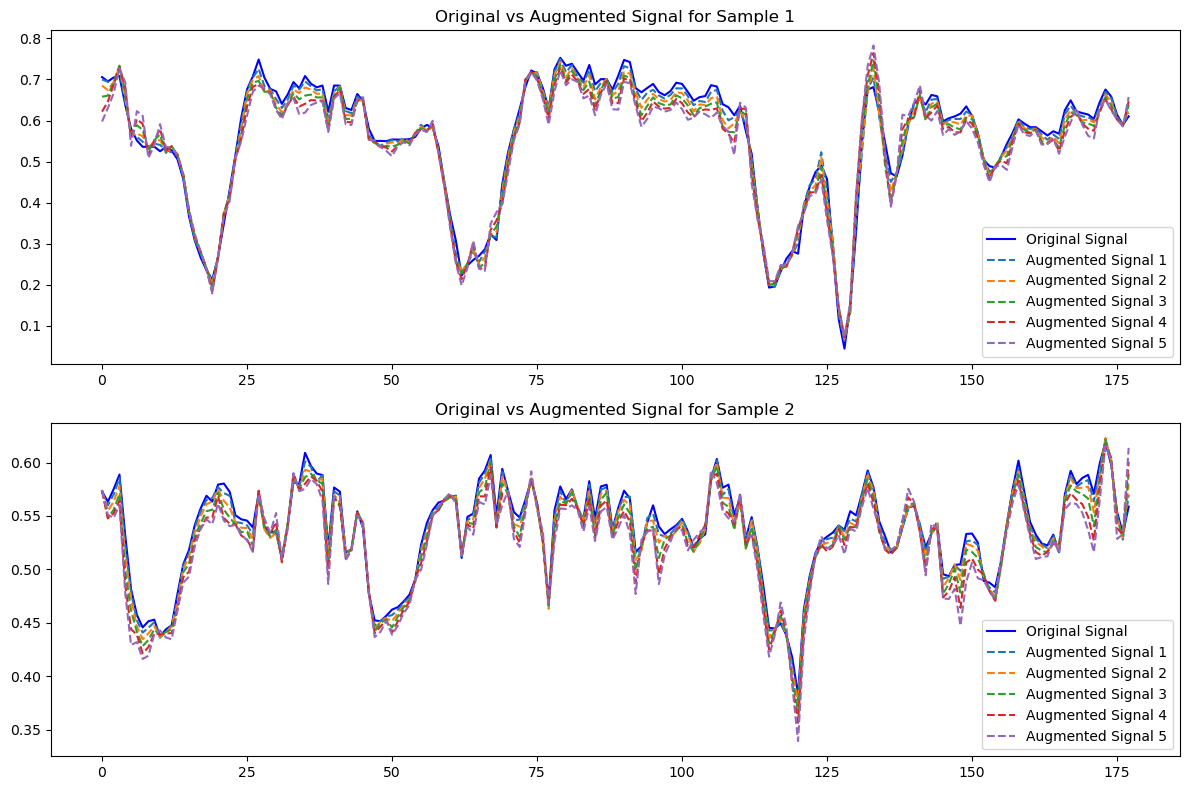

In [118]:
# Example usage
autoencoder = load_model("../models/autoencoder.h5")
n_augmentations = 5
first_two_augmented_signals = []
for sample_idx in range(2):
    # Augment each signal 5 times
    augmented_signals = augment_signal_n_times(X_train_scaled[sample_idx], autoencoder, n=n_augmentations)
    first_two_augmented_signals.append(np.array(augmented_signals))

plot_original_vs_augmented(X_train_scaled[:2].squeeze(), first_two_augmented_signals, n_augmentations)

### 4. Augmented Dataset Generation

We use two approaches to generate augmented datasets:

1. **Balanced Training Dataset**:  
   Since the training dataset is imbalanced, with 80% non-seizure data and 20% seizure data, we augment only the seizure data. The augmentation continues until the training set contains an equal number of non-seizure and seizure samples.

2. **Augmenting the Entire Training Set**:  
   In this approach, we augment the entire training set by 5 times, increasing the variations in the dataset regardless of the labels.

#### 4.1 No dropout model

In [119]:
autoencoder = load_model("../models/autoencoder.h5")

In [15]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([8275, 1964]))

##### 4.1.1 Only augment the seizure label

In [11]:
def balance_dataset(X_train, y_train, autoencoder, n_feedback=5):
    """
    Augments seizure data iteratively using feedback-based augmentation to balance it with non-seizure data.

    Parameters:
    - X_train: numpy array of training data (features).
    - y_train: numpy array of training labels (0 for non-seizure, 1 for seizure).
    - autoencoder: trained autoencoder model for generating augmentations.
    - n_feedback: number of feedback iterations for augmenting seizure samples.

    Returns:
    - augmented_X: numpy array of augmented training data.
    - augmented_y: numpy array of corresponding labels.
    """
    # Reshape X_train if needed to ensure 3D shape (e.g., (samples, 178, 1))
    if X_train.ndim == 2:
        X_train = X_train[..., np.newaxis]

    # Count the samples for each class
    class_counts = np.bincount(y_train)
    n_seizure_samples = class_counts[1]
    n_non_seizure_samples = class_counts[0]
    n_augmentations_needed = n_non_seizure_samples - n_seizure_samples

    print(f"Non-seizure samples: {n_non_seizure_samples}")
    print(f"Seizure samples: {n_seizure_samples}")
    print(f"Augmentations required: {n_augmentations_needed}")

    # Separate samples by class
    X_non_seizure = X_train[y_train == 0]
    X_seizure = X_train[y_train == 1]

    # Initialize lists to store augmented data and labels
    augmented_X = []
    augmented_y = []

    # Add original non-seizure data
    for x in X_non_seizure:
        augmented_X.append(x.flatten())  # Flatten for saving as rows in CSV
        augmented_y.append(0)

    # Add original seizure data
    for x in X_seizure:
        augmented_X.append(x.flatten())
        augmented_y.append(1)

    # Generate augmented samples for seizure data
    seizure_count = len(X_seizure)
    for i in tqdm(range(n_augmentations_needed), desc="Generating augmentations"):
        original_signal = X_seizure[i % len(X_seizure)]  # Use 3D shape directly
        augmented_signals = augment_signal_n_times(original_signal, autoencoder, n=n_feedback)

        # Add only the required number of augmentations
        for aug_signal in augmented_signals:
            if seizure_count >= n_non_seizure_samples:  # Stop if balanced
                break
            augmented_X.append(aug_signal.flatten()) 
            augmented_y.append(1)
            seizure_count += 1

    # Convert lists to arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    # Combine features and labels into a DataFrame for verification
    augmented_df = pd.DataFrame(augmented_X)
    augmented_df['label'] = augmented_y
    print("Label distribution in augmented dataset (actual labels):\n", augmented_df['label'].value_counts())

    return augmented_X, augmented_y

In [121]:
# Augment the dataset
X_train_augmented, y_train_augmented = balance_dataset(X_train, y_train, autoencoder)

Non-seizure samples: 8275
Seizure samples: 1964
Augmentations required: 6311


Generating augmentations: 100%|██████████| 6311/6311 [27:27<00:00,  3.83it/s]

Label distribution in augmented dataset (actual labels):
 label
0    8275
1    8275
Name: count, dtype: int64


Epoch 1/30
414/414 [==============================] - 12s 22ms/step - loss: 0.9368 - accuracy: 0.9356 - val_loss: 5.0858 - val_accuracy: 0.6233
Epoch 2/30
414/414 [==============================] - 9s 21ms/step - loss: 0.6084 - accuracy: 0.9715 - val_loss: 0.1179 - val_accuracy: 0.9900
Epoch 3/30
414/414 [==============================] - 9s 21ms/step - loss: 0.5607 - accuracy: 0.9718 - val_loss: 0.2386 - val_accuracy: 0.9870
Epoch 4/30
414/414 [==============================] - 9s 21ms/step - loss: 0.4415 - accuracy: 0.9798 - val_loss: 0.5438 - val_accuracy: 0.9764
Epoch 5/30
414/414 [==============================] - 9s 21ms/step - loss: 0.2183 - accuracy: 0.9878 - val_loss: 0.0986 - val_accuracy: 0.9927
Epoch 6/30
414/414 [==============================] - 9s 23ms/step - loss: 0.3894 - accuracy: 0.9813 - val_loss: 0.1402 - val_accuracy: 0.9949
Epoch 7/30
414/414 [==============================] - 9s 21ms/step - loss: 0.3428 - accuracy: 0.9854 - val_loss: 0.1543 - val_accuracy: 0.993

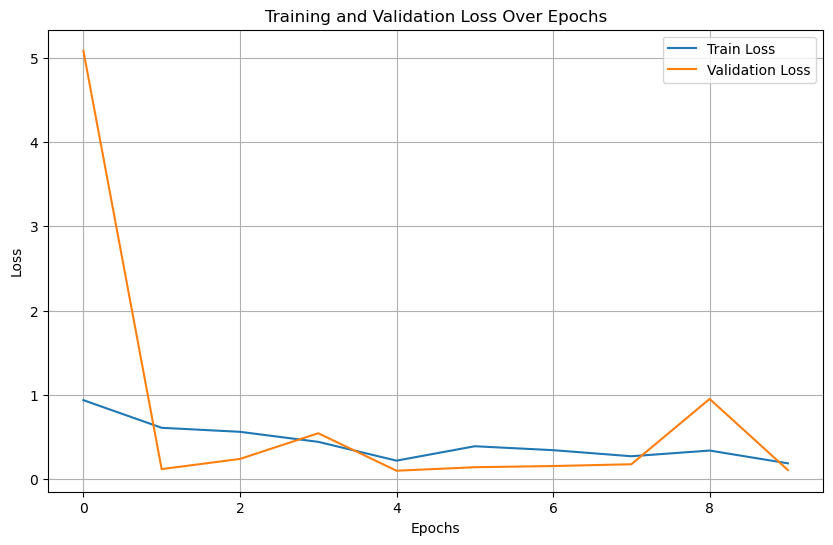

In [122]:
# Evaluate on detection task
train_and_test_classification(X_train_augmented, y_train_augmented, X_test, y_test)

##### 4.1.2 Augmenting the Entire Training Set

In [6]:
def augment_entire_dataset(X_train, y_train, autoencoder, n_augmentations=5):
    """
    Augment the entire dataset using feedback-based augmentation.

    Parameters:
    - X_train: numpy array of training data (features).
    - y_train: numpy array of training labels.
    - autoencoder: trained autoencoder model for generating augmentations.
    - n_augmentations: number of iterations to feed the reconstructed signal back into the autoencoder.

    Returns:
    - augmented_X: numpy array of augmented training data.
    - augmented_y: numpy array of corresponding labels.
    """
    # Reshape X_train if needed to ensure 3D shape (e.g., (samples, 178, 1))
    if X_train.ndim == 2:
        X_train = X_train[..., np.newaxis]

    # Initialize lists to store augmented data and labels
    augmented_X = []
    augmented_y = []

    # Add original data
    for x, y in zip(X_train, y_train):
        augmented_X.append(x.flatten())  # Flatten for saving as rows in CSV
        augmented_y.append(y)

    # Generate feedback-based augmentations for each sample in X_train
    for i in tqdm(range(len(X_train)), desc="Generating augmentations"):
        original_signal = X_train[i]  # Use the 3D signal directly (no flattening here)
        augmented_signals = augment_signal_n_times(original_signal, autoencoder, n=n_augmentations)

        # Append all generated augmented signals and their corresponding labels
        for aug_signal in augmented_signals:
            augmented_X.append(aug_signal.flatten())  # Flatten the augmented signal before saving
            augmented_y.append(y_train[i])  # Corresponding label

    # Convert lists to arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    # Combine features and labels into a DataFrame for verification
    augmented_df = pd.DataFrame(augmented_X)
    augmented_df['label'] = augmented_y
    print("Label distribution in augmented dataset:\n", augmented_df['label'].value_counts())

    return augmented_X, augmented_y

In [9]:
autoencoder = load_model("../models/autoencoder.h5")
X_train_augmented, y_train_augmented = augment_entire_dataset(X_train, y_train, autoencoder)

Generating augmentations: 100%|██████████| 10239/10239 [43:30<00:00,  3.92it/s]


Label distribution in augmented dataset:
 label
0    49650
1    11784
Name: count, dtype: int64


Epoch 1/30
1536/1536 [==============================] - 33s 20ms/step - loss: 1.5387 - accuracy: 0.7625 - val_loss: 0.8265 - val_accuracy: 0.8112
Epoch 2/30
1536/1536 [==============================] - 31s 20ms/step - loss: 0.8132 - accuracy: 0.7822 - val_loss: 0.7024 - val_accuracy: 0.8236
Epoch 3/30
1536/1536 [==============================] - 31s 20ms/step - loss: 0.7219 - accuracy: 0.7879 - val_loss: 0.6569 - val_accuracy: 0.8304
Epoch 4/30
1536/1536 [==============================] - 31s 20ms/step - loss: 0.6530 - accuracy: 0.7986 - val_loss: 0.5146 - val_accuracy: 0.8348
Epoch 5/30
1536/1536 [==============================] - 31s 20ms/step - loss: 0.6183 - accuracy: 0.8036 - val_loss: 0.5678 - val_accuracy: 0.8342
Epoch 6/30
1536/1536 [==============================] - 31s 20ms/step - loss: 0.5722 - accuracy: 0.8115 - val_loss: 0.4489 - val_accuracy: 0.8361
Epoch 7/30
1536/1536 [==============================] - 31s 20ms/step - loss: 0.5640 - accuracy: 0.8184 - val_loss: 0.5705 -

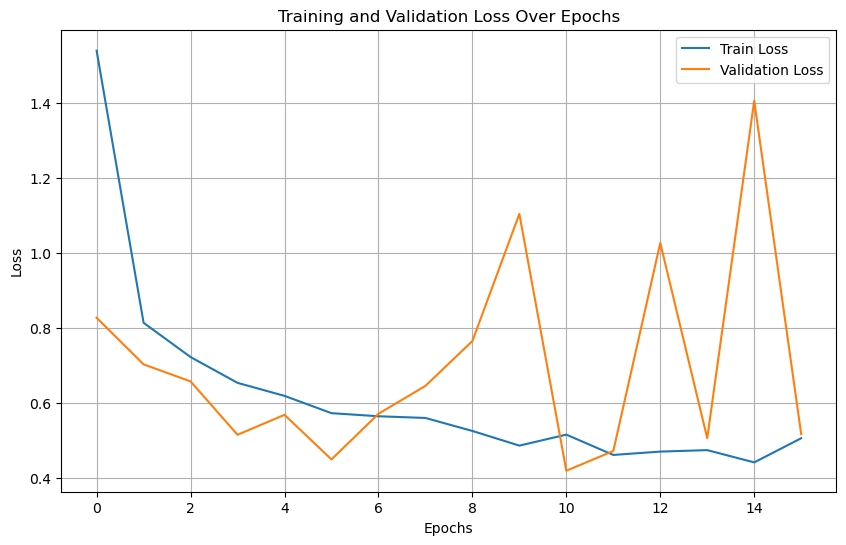

In [16]:
# Evaluate on detection task
train_and_test_classification(X_train_augmented, y_train_augmented, X_test, y_test)

#### 4.2 Autoencoder with dropout

In [5]:
autoencoder_dropout = load_model("../models/autoencoder_2d_dropout.h5")

##### 4.2.1 Only augment the seizure label

In [12]:
# Augment the dataset
X_train_dropout, y_train_dropout = balance_dataset(X_train, y_train, autoencoder_dropout)

Non-seizure samples: 8275
Seizure samples: 1964
Augmentations required: 6311


Generating augmentations:   0%|          | 0/6311 [00:00<?, ?it/s]

2024-11-28 06:50:31.095706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
Generating augmentations: 100%|██████████| 6311/6311 [26:42<00:00,  3.94it/s]

Label distribution in augmented dataset (actual labels):
 label
0    8275
1    8275
Name: count, dtype: int64


Epoch 1/30


2024-11-28 07:17:35.053984: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5602443e6260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-28 07:17:35.054020: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-28 07:17:35.093448: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 07:17:35.325786: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


414/414 [==============================] - 12s 21ms/step - loss: 2.3307 - accuracy: 0.6757 - val_loss: 2.5082 - val_accuracy: 0.8755
Epoch 2/30
414/414 [==============================] - 8s 20ms/step - loss: 0.8574 - accuracy: 0.8776 - val_loss: 0.2417 - val_accuracy: 0.9776
Epoch 3/30
414/414 [==============================] - 8s 20ms/step - loss: 0.0975 - accuracy: 0.9844 - val_loss: 0.2457 - val_accuracy: 0.9789
Epoch 4/30
414/414 [==============================] - 8s 20ms/step - loss: 0.0569 - accuracy: 0.9912 - val_loss: 0.0466 - val_accuracy: 0.9909
Epoch 5/30
414/414 [==============================] - 8s 20ms/step - loss: 0.0532 - accuracy: 0.9921 - val_loss: 0.0197 - val_accuracy: 0.9958
Epoch 6/30
414/414 [==============================] - 8s 20ms/step - loss: 0.0557 - accuracy: 0.9934 - val_loss: 0.2175 - val_accuracy: 0.9870
Epoch 7/30
414/414 [==============================] - 8s 20ms/step - loss: 0.0691 - accuracy: 0.9931 - val_loss: 0.1411 - val_accuracy: 0.9891
Epoch 8/3

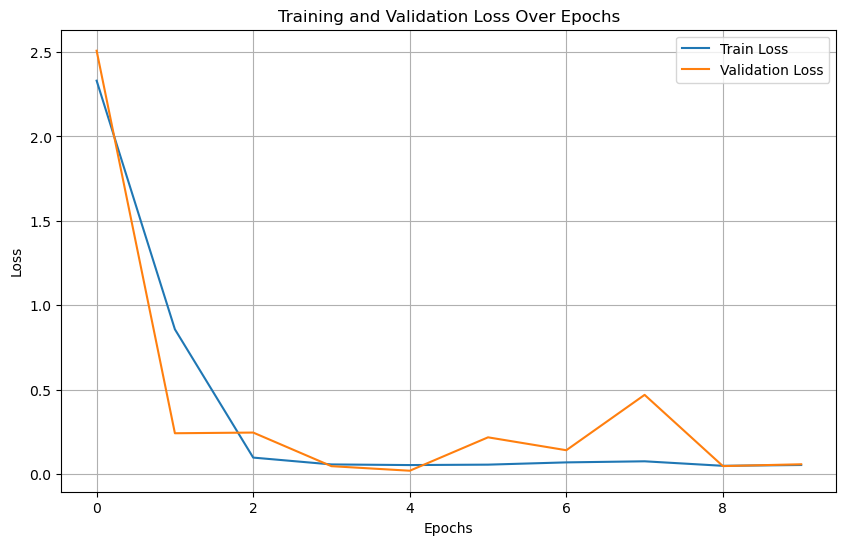

In [13]:
# Evaluate on detection task
train_and_test_classification(X_train_dropout, y_train_dropout, X_test, y_test)

##### 4.2.2 Augmenting the Entire Training Set

In [10]:
# Augment the dataset
X_train_dropout, y_train_dropout = augment_entire_dataset(X_train, y_train, autoencoder_dropout)

Generating augmentations:   0%|          | 0/10239 [00:00<?, ?it/s]

2024-11-28 22:39:53.707921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
Generating augmentations: 100%|██████████| 10239/10239 [37:44<00:00,  4.52it/s]


Label distribution in augmented dataset:
 label
0    49650
1    11784
Name: count, dtype: int64


Epoch 1/30
1536/1536 [==============================] - 31s 19ms/step - loss: 1.7046 - accuracy: 0.7549 - val_loss: 1.0091 - val_accuracy: 0.8017
Epoch 2/30
1536/1536 [==============================] - 29s 19ms/step - loss: 0.8135 - accuracy: 0.7870 - val_loss: 1.1854 - val_accuracy: 0.3637
Epoch 3/30
1536/1536 [==============================] - 29s 19ms/step - loss: 0.7124 - accuracy: 0.8068 - val_loss: 1.3127 - val_accuracy: 0.8028
Epoch 4/30
1536/1536 [==============================] - 29s 19ms/step - loss: 0.6855 - accuracy: 0.8054 - val_loss: 0.5177 - val_accuracy: 0.8321
Epoch 5/30
1536/1536 [==============================] - 29s 19ms/step - loss: 0.6606 - accuracy: 0.8088 - val_loss: 0.5517 - val_accuracy: 0.8284
Epoch 6/30
1536/1536 [==============================] - 29s 19ms/step - loss: 0.5727 - accuracy: 0.8168 - val_loss: 0.4755 - val_accuracy: 0.8358
Epoch 7/30
1536/1536 [==============================] - 29s 19ms/step - loss: 0.5681 - accuracy: 0.8161 - val_loss: 0.4650 -

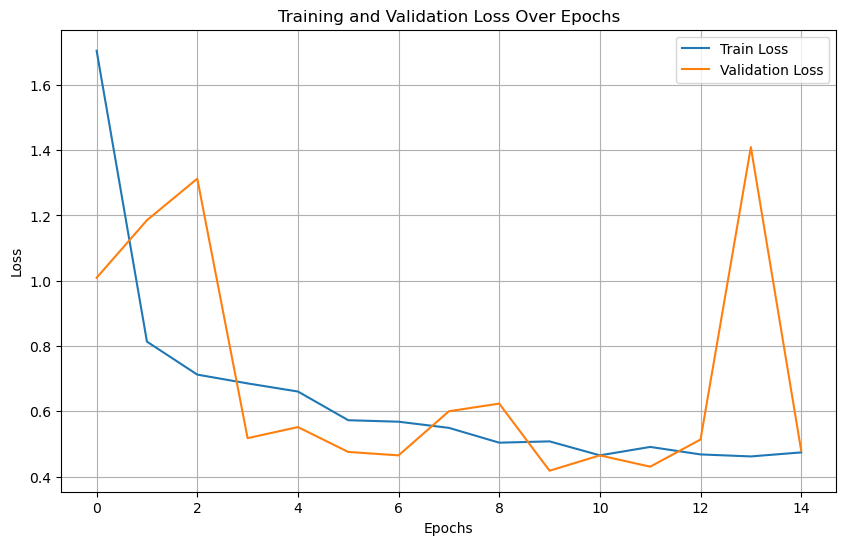

In [13]:
# Evaluate on detection task
train_and_test_classification(X_train_dropout, y_train_dropout, X_test, y_test)

### Conclusion:

1. **Dropout Analysis**:
   - The autoencoder without dropout achieved the best MSE and reconstruction performance.
   - However, adding dropout to autoencoder can introduce more variations in the reconstructed signals. The effectiveness can be proved by the high seizure recall after adding dropout to autoencoder.

2. **Data Augmentation Strategies**:
   - Augmenting the entire dataset outperformed augmenting only the minority label (seizure), highlighting the importance of data quantity for this problem.

3. **Impact of Data Augmentation**:
   - Data augmentation improved all evaluation metrics, demonstrating its effectiveness in enhancing model performance for seizure detection.


### Metrics Before and After Augmentation:
<table>
  <tr>
    <th rowspan="1">Metric</th>
    <th rowspan="1">Before Augmentation</th>
    <th colspan="2">After Augmentation - No dropout</th>
    <th colspan="2">After Augmentation - With dropout</th>
  </tr>
  <tr>
    <th>Data Split(Non-seizure: Seizure)</th>
    <th>8275:1964</th>
    <th>8275:8275</th>
    <th>49650:11784</th>
    <th>8275:8275</th>
    <th>49650:11784</th>
  </tr>
  <tr>
    <td><b>Recall (Seizure Activity)</b></td>
    <td>45.24%</td>
    <td>37.50%</td>
    <td>63.39%</td>
    <td><b>77.98%</b></td>
    <td>63.69%</td>
  </tr>
  <tr>
    <td><b>F1 Score (Detection)</b></td>
    <td>67.93%</td>
    <td>71.26%</td>
    <td><b>76.81%</b></td>
    <td>73.82%</td>
    <td>75.65%</td>
  </tr>
  <tr>
    <td><b>ROC-AUC (Detection)</b></td>
    <td>69.01%</td>
    <td>75.61%</td>
    <td><b>80.78%</b></td>
    <td>80.22%</td>
    <td>79.32%</td>
  </tr>
  <tr>
    <td><b>Cohen's Kappa (Detection)</b></td>
    <td>19.77%</td>
    <td>24.23%</td>
    <td><b>42.24%</b></td>
    <td>40.53%</td>
    <td>39.99%</td>
  </tr>
</table>